In [1]:
# In the mass sheet degeneracy, one could also use a mass disk. This will then
# cause the rescaling of the source to take place in the direction of the
# center of the disk. Using a second disk with the inverse scaling, but towards
# a different location, then has as the net effect that the original source
# will have been moved.

In [2]:
# Load some modules and set some defaults
%matplotlib inline
from grale.all_nb import *

LI = plotutil.LensInfo
feedback.setDefaultFeedback("none")

Set 'threads' as default renderer for lensplane and mass density
Set default angular unit in plotting to arcsec
Set feedback style to 'notebook'


In [3]:
# Redshifts and corresponding angular diameter distances
cosm = cosmology.Cosmology(0.71,0.27,0,0.73)
zd = 0.5
zs = 1.2
Dd = cosm.getAngularDiameterDistance(zd)
Ds = cosm.getAngularDiameterDistance(zs)
Dds = cosm.getAngularDiameterDistance(zd,zs)

In [4]:
# The core lens will be an NSIE
nsie = lenses.NSIELens(Dd, { 
        "velocityDispersion": 1300000, 
        "ellipticity": 0.8, 
        "coreRadius": 1.5*ANGLE_ARCSEC})

In [5]:
# We'll be plotting the density on a larger region than the image plane,
# so we'll use two settings
lensInfo = LI(nsie, size=200*ANGLE_ARCSEC)
lensInfo2 = LI(nsie, size=80*ANGLE_ARCSEC, Ds=Ds, Dds=Dds)

In [6]:
# The density of the NSIE
plotutil.plotDensityInteractive(lensInfo, numX=100, numY=100);

In [7]:
# Specify our original source and original location
xCenter, yCenter = 10, 5
src = images.EllipticalSource(V(xCenter,yCenter)*ANGLE_ARCSEC, eccentricity = 0.6, 
                              halfAxis = 1.1*ANGLE_ARCSEC,angle = 30)

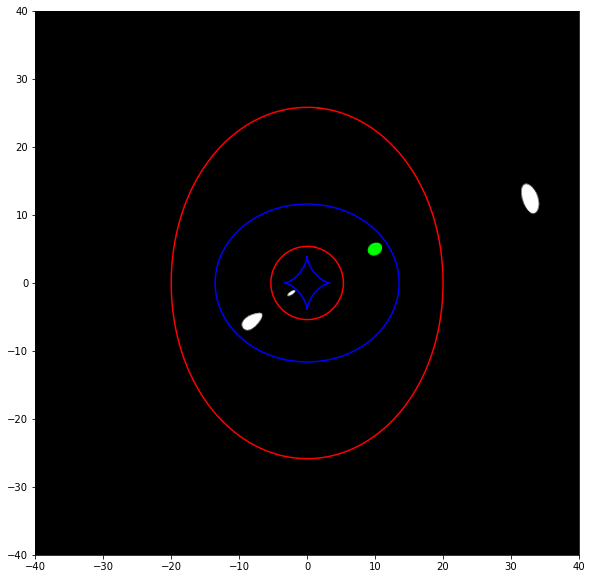

In [8]:
# And plot the image plane
plt.figure(figsize=(10,10))
plotutil.plotImagePlane(lensInfo2, sources=[ src ]);

In [9]:
# Here is a helper function that, for a given lens, constructs the
# mass disk degenerate version for a specific factor 'lambdaValue'.
# 'radius' is the main radius of the disk, if an 'andradius' is specified
# as well, then the density will drop smoothly to zero at that radius.
# Otherwise it just goes to zero abruptly
def createDiskDegeneracy(lens, lambdaValue, Ds, Dds, center, radius, endradius = None):
    Dd = lens.getLensDistance()
    critDens = lens.getCriticalDensity(Ds, Dds)
    if endradius is None:
        disk = lenses.MassDiskLens(Dd, { "Dd": Dd, "Ds": Ds, "Dds": Dds, "radius": radius })
    else:
        disk = lenses.MassDiskLensSmoothed( Dd, { "Dd": Dd, "Ds": Ds, "Dds": Dds, 
                                                  "radius": radius, "endradius": endradius })

    compLens = lenses.CompositeLens(Dd, [
        {
            "lens": lens,
            "factor": lambdaValue,
            "angle": 0,
            "x": 0,
            "y": 0
        },
        {
            "lens": disk,
            "factor": (1.0-lambdaValue),
            "angle": 0,
            "x": center[0],
            "y": center[1]
        }
    ])

    return compLens

In [10]:
# Here we're going to do the construction mentioned at the start: with the first
# mass disk degenerate lens, a source will be scale according to 'l' towards the
# center of the disk. Then, a second degenerate lens is created that uses the
# inverse scaling 1/l to rescale the source to its original size, but towards
# a different center. 
l = 0.75
degen = createDiskDegeneracy(nsie, l, Ds, Dds, V(0,0)*ANGLE_ARCSEC, 75*ANGLE_ARCSEC, 90*ANGLE_ARCSEC)
degen2 = createDiskDegeneracy(degen, 1.0/l, Ds, Dds, V(xCenter,yCenter)*ANGLE_ARCSEC, 50*ANGLE_ARCSEC, 60*ANGLE_ARCSEC)
lensInfoDegen = LI(degen2, size=200*ANGLE_ARCSEC)
lensInfoDegen2 = LI(degen2, size=80*ANGLE_ARCSEC, Ds=Ds, Dds=Dds)

In [11]:
# The effect of the two disks is an annulus-like region
plotutil.plotDensityInteractive(lensInfoDegen, numX=100, numY=100);

In [12]:
# This second source has the same shape as the original, but is placed 
# in a different location, so that the images will still be the same
src2 = images.EllipticalSource(V((xCenter*l-xCenter)/l+xCenter,(yCenter*l-yCenter)/l+yCenter)*ANGLE_ARCSEC, 
                               eccentricity = 0.6, halfAxis = 1.1*ANGLE_ARCSEC,angle = 30)

Original source position: [10.  5.]
Moved source position: [6.66666667 3.33333333]


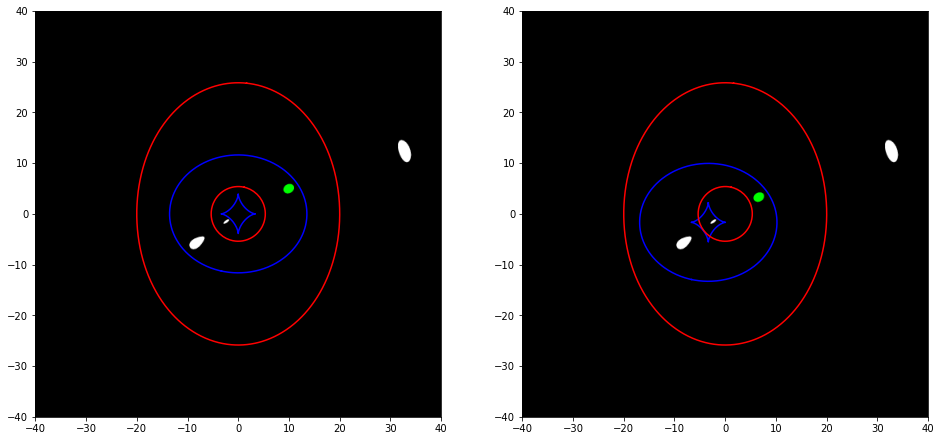

In [13]:
# Plot the original and new image planes. The source has been placed in the
# location that creates te same images, but you can also see that the source 
# plane has been moved by comparing the caustics in the two figures.
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plotutil.plotImagePlane(lensInfo2, sources=[ src ]);
plt.subplot(1,2,2)
plotutil.plotImagePlane(lensInfoDegen2, sources=[ src2 ]);
print("Original source position:", src.getAngularPosition()/ANGLE_ARCSEC)
print("Moved source position:", src2.getAngularPosition()/ANGLE_ARCSEC)

In [14]:
# The following function creates only the ring-like part. It is this mass distribution that was
# added to the original one ('lens') to create the moved-source effect.

def createRingOnly(lens, lambdaValue, Ds, Dds, center1, radius1, endradius1, center2, radius2, endradius2):
    Dd = lens.getLensDistance()
    critDens = lens.getCriticalDensity(Ds, Dds)

    disk1 = lenses.MassDiskLensSmoothed( Dd, { "Dd": Dd, "Ds": Ds, "Dds": Dds, 
                                                "radius": radius1, "endradius": endradius1 })
    disk2 = lenses.MassDiskLensSmoothed( Dd, { "Dd": Dd, "Ds": Ds, "Dds": Dds, 
                                                "radius": radius2, "endradius": endradius2 })

    compLens = lenses.CompositeLens(Dd, [
        {
            "lens": disk1,
            "factor": (1.0/lambdaValue-1),
            "angle": 0,
            "x": center1[0],
            "y": center1[1]
        },
        {
            "lens": disk2,
            "factor": (1-1.0/lambdaValue),
            "angle": 0,
            "x": center2[0],
            "y": center2[1]
        }
    ])

    return compLens


In [15]:
# Here this part of the mass distribution is created, so the same parameters are used as before
ringPart = createRingOnly(nsie, l, Ds, Dds, V(0,0)*ANGLE_ARCSEC, 75*ANGLE_ARCSEC, 90*ANGLE_ARCSEC,
                          V(xCenter,yCenter)*ANGLE_ARCSEC, 50*ANGLE_ARCSEC, 60*ANGLE_ARCSEC)

In [16]:
lensInfoRing = LI(ringPart, size=200*ANGLE_ARCSEC)

In [17]:
# To illustrate that this is the ring-like part that was added, let's plot this
plotutil.plotDensityInteractive(lensInfoRing, numX=100, numY=100, visJSoptions={"zMax": 30});

In [18]:
# A helper function to create a grid of theta values
def createThetaGrid(bottomLeft, topRight, numX, numY):
    thetas = np.empty([numY,numX,2], dtype=np.double)
    thetas[:,:,0], thetas[:,:,1] = np.meshgrid(np.linspace(bottomLeft[0], topRight[0], numX), 
                                               np.linspace(bottomLeft[1], topRight[1], numY))
    return thetas

In [19]:
# Create a grid of theta-positions for a 100x100 arcsec^2 region
thetas100 = createThetaGrid(-V(50,50)*ANGLE_ARCSEC, V(50,50)*ANGLE_ARCSEC, 100, 100)

In [20]:
# Plot the projected potential for this region. In the innermost part, this is just a plane.
phi = ringPart.getProjectedPotential(1,1,thetas100)
phi -= phi.min()
plotutil.plot3DInteractive(thetas100[:,:,0]/ANGLE_ARCSEC,thetas100[:,:,1]/ANGLE_ARCSEC, phi/ANGLE_ARCSEC**2)

In [21]:
# When a projected potential psi_0 is given, you can construct a new one

$$\psi_1(\vec{\theta}) = \psi_0(\vec{\theta}) + \vec{c}\cdot\vec{\theta} + \rm{offset}$$

In [22]:
# that changes the deflection angles by a constant value but has no observable effect
# (the source position is not observable). This linear part is the same as what one 
# obtains by the construction above.